In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Activation functions
class ReLU:
    def forward(self,x):
        self.x=x
        return np.maximum(0,x)

    def backward(self,dout):
        return dout * (self.x>0)
    
class sigmoid:
    def forward(self,x):
        self.out=1/(1+np.exp(-np.clip(x,-500,500)))
        return self.out
    def backward(self,dout):
        return dout*self.out*(1-self.out)
    
class tanh:
    def forward(self,x):
        self.out=np.tanh(x)
        return self.out

    def backward(self,dout):
        return dout*(1-self.out**2)
    
class softmax: 
   def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.out = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.out
   def backward(self,dout):
    return dout

# LOSS FUNCTIONS
class MSE:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred-y_true)**2)

    def backward(self):
        return 2 * (self.y_pred - self.y_true) / self.y_true.shape[0]
        
class MAE:
    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean(np.abs(y_pred-y_true))
    
    def backward(self):
        return np.sign(self.y_pred - self.y_true) / self.y_true.shape[0]

class CrossEntropy:
    def forward(self, y_pred, y_true):
        self.y_pred =  np.clip(y_pred, 1e-10, 1 - 1e-10) 
        self.y_true = y_true
        return -np.mean(np.sum(y_true * np.log(self.y_pred), axis=1))
    
    def backward(self):
        return (self.y_pred - self.y_true) / self.y_true.shape[0]



#Dense layer

class Dense:
    def __init__(self,input_dim,output_dim):

        self.W=np.random.randn(input_dim,output_dim)*np.sqrt(2.0/input_dim)
        self.b=np.zeros((1,output_dim))

    def forward(self,x):
        self.x=x
        return np.dot(x,self.W)+self.b
    
    def backward(self,dout,lr):
        dW=np.dot(self.x.T,dout)
        db=np.sum(dout,axis=0,keepdims=True)
        dx=np.dot(dout,self.W.T)

        self.W-=lr*dW
        self.b-=lr*db

        return dx
    
class MLP:

    def __init__(self,layersizes,activation='relu',loss='crossentropy'):
        self.layers=[]
        self.activations=[]
        

        for i in range(len(layersizes)-1):
            self.layers.append(Dense(layersizes[i],layersizes[i+1]))

            # Add activation for hidden layers
            if i < len(layersizes) - 2:
                if activation=='relu':
                    self.activations.append(ReLU())
                elif activation=='sigmoid':
                    self.activations.append(sigmoid())
                elif activation=="tanh":
                    self.activations.append(tanh())
            else:
                # Output layer softmax
                self.activations.append(softmax())

        if loss=='crossentropy':
            self.loss_fn=CrossEntropy()
        elif loss=='mse':
            self.loss_fn=MSE()
        elif loss=="mae":
            self.loss_fn=MAE()    

    def forward(self,x):
        for layer,activation in zip(self.layers,self.activations):
            x = layer.forward(x)
            x = activation.forward(x)
        return x
    
    def backward(self,lr):
        dout=self.loss_fn.backward()

        for layer,activation in reversed(list(zip(self.layers,self.activations))):
            dout = activation.backward(dout)
            dout = layer.backward(dout,lr)


    def train(self,X,y,epochs,lr,batch_size=32,X_val=None,y_val=None,verbose=True):

        history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}

        for epoch in range(epochs):

            indices=np.random.permutation(len(X))
            X_shuffled=X[indices]
            y_shuffled=y[indices]

            epoch_loss=0
            batches=0

            for i in range(0,len(X),batch_size):
                X_batch=X_shuffled[i:i+batch_size]
                y_batch=y_shuffled[i:i+batch_size]

                y_pred=self.forward(X_batch)
                loss=self.loss_fn.forward(y_pred,y_batch)

                self.backward(lr)

                epoch_loss+=loss
                batches+=1

            train_loss=epoch_loss/batches
            train_acc=self.accuracy(X,y)
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            if X_val is not None and y_val is not None:
                    val_pred=self.forward(X_val)
                    val_loss=self.loss_fn.forward(val_pred,y_val)
                    val_acc=self.accuracy(X_val,y_val)
                    history['val_loss'].append(val_loss)
                    history['val_acc'].append(val_acc)
                    
                    if verbose and (epoch + 1) % 10 == 0:
                        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        
        return history
                
    def predict(self,X):
        return self.forward(X)
    
    def accuracy(self,X,y):
        y_pred=self.predict(X)
        pred_labels=np.argmax(y_pred,axis=1)
        true_labels=np.argmax(y,axis=1)
        return np.mean(pred_labels==true_labels)

    



In [27]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    if 'val_loss' in history and history['val_loss']:
        ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training History - Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Acc')
    if 'val_acc' in history and history['val_acc']:
        ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training History - Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), cmap='viridis', edgecolors='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

Neural Network from Scratch - Complete Implementation
EXPERIMENT 1: MNIST Classification
Epoch 10/100 - Loss: 0.6035, Acc: 0.9123, Val Loss: 0.5724, Val Acc: 0.9194
Epoch 20/100 - Loss: 0.2915, Acc: 0.9471, Val Loss: 0.2915, Val Acc: 0.9278
Epoch 30/100 - Loss: 0.1996, Acc: 0.9624, Val Loss: 0.2110, Val Acc: 0.9361
Epoch 40/100 - Loss: 0.1545, Acc: 0.9694, Val Loss: 0.1695, Val Acc: 0.9472
Epoch 50/100 - Loss: 0.1283, Acc: 0.9749, Val Loss: 0.1481, Val Acc: 0.9472
Epoch 60/100 - Loss: 0.1098, Acc: 0.9777, Val Loss: 0.1327, Val Acc: 0.9556
Epoch 70/100 - Loss: 0.0958, Acc: 0.9826, Val Loss: 0.1224, Val Acc: 0.9583
Epoch 80/100 - Loss: 0.0852, Acc: 0.9840, Val Loss: 0.1169, Val Acc: 0.9667
Epoch 90/100 - Loss: 0.0765, Acc: 0.9875, Val Loss: 0.1124, Val Acc: 0.9694
Epoch 100/100 - Loss: 0.0692, Acc: 0.9889, Val Loss: 0.1086, Val Acc: 0.9694

Final Test Accuracy: 96.94%


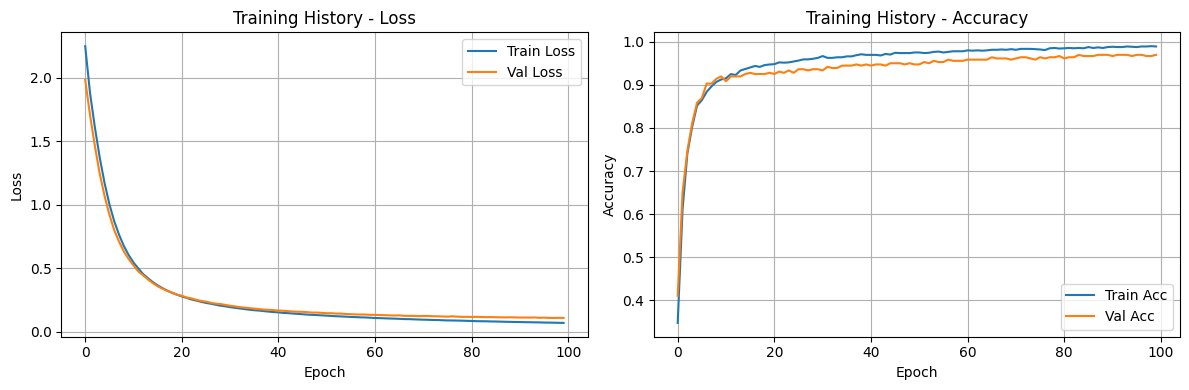


EXPERIMENT 2: Activation Function Comparison

Training with RELU...
Final Accuracy: 87.60%

Training with SIGMOID...
Final Accuracy: 79.60%

Training with TANH...
Final Accuracy: 89.60%


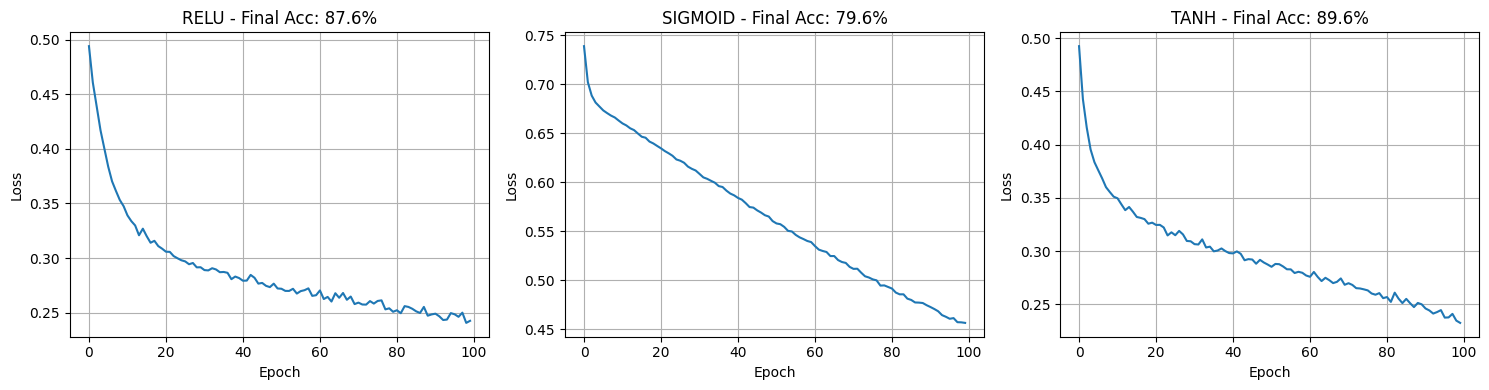

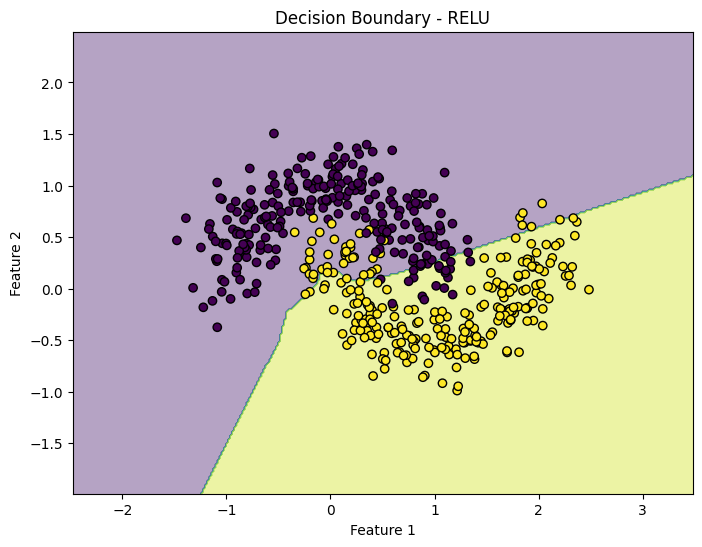

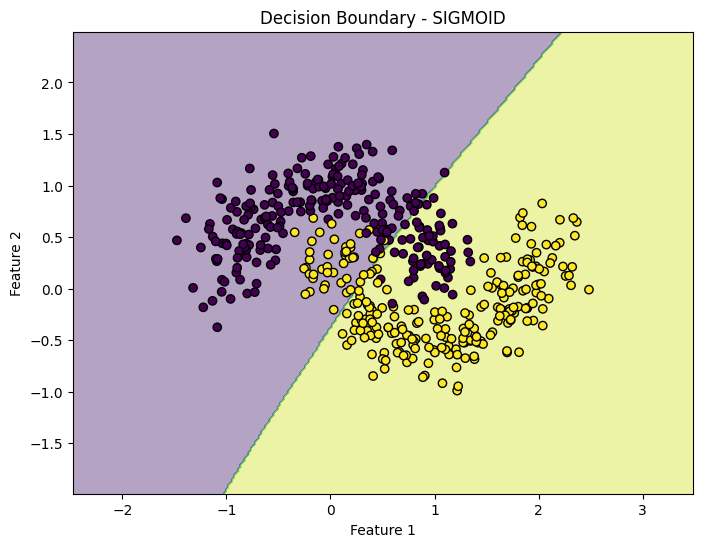

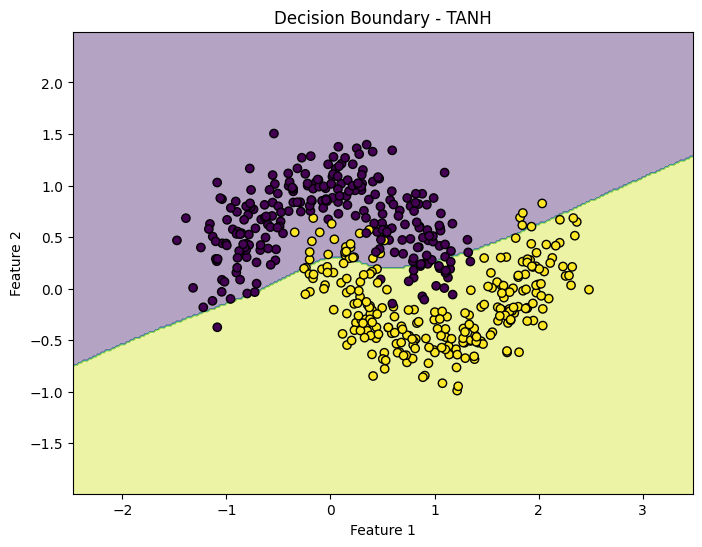


EXPERIMENT 3: Loss Function Comparison

Training with CROSSENTROPY...
Final Accuracy: 98.40%

Training with MSE...
Final Accuracy: 99.20%


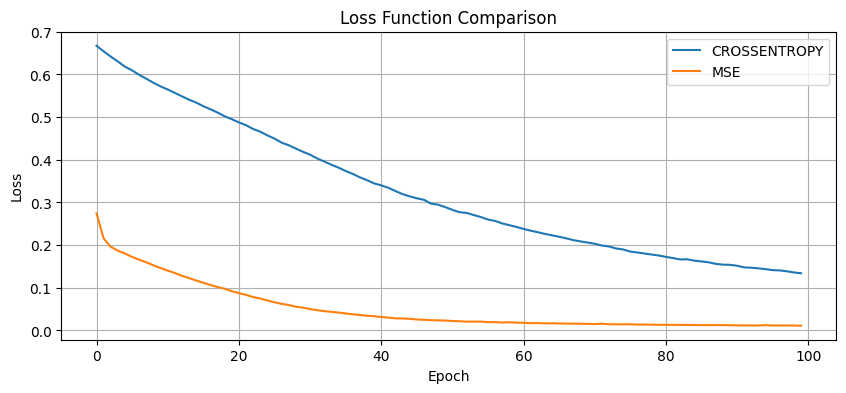


ALL EXPERIMENTS COMPLETE!


In [28]:
def experiment_mnist():
 
    print("=" * 60)
    print("EXPERIMENT 1: MNIST Classification")
    print("=" * 60)
    
    # Load MNIST (using digits dataset for faster loading)
    from sklearn.datasets import load_digits
    digits = load_digits()
    X, y = digits.data, digits.target
    
    # Normalize
    X = X / 16.0
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # One-hot encode
    y_train_oh = one_hot_encode(y_train, 10)
    y_test_oh = one_hot_encode(y_test, 10)
    
    # Build and train model
    model = MLP([64, 128, 64, 10], activation='relu', loss='crossentropy')
    history = model.train(X_train, y_train_oh, epochs=100, lr=0.01, batch_size=32, 
                          X_val=X_test, y_val=y_test_oh)
    
    # Final accuracy
    test_acc = model.accuracy(X_test, y_test_oh)
    print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
    
    plot_history(history)
    
    return model, history

def experiment_activations():
    """Compare different activation functions"""
    print("\n" + "=" * 60)
    print("EXPERIMENT 2: Activation Function Comparison")
    print("=" * 60)
    
    # Create toy dataset
    X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
    y_oh = one_hot_encode(y, 2)
    
    activations = ['relu', 'sigmoid', 'tanh']
    results = {}
    
    for act in activations:
        print(f"\nTraining with {act.upper()}...")
        model = MLP([2, 16, 16, 2], activation=act, loss='crossentropy')
        history = model.train(X, y_oh, epochs=100, lr=0.01, verbose=False)
        results[act] = (model, history)
        print(f"Final Accuracy: {history['train_acc'][-1]*100:.2f}%")
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, act in enumerate(activations):
        model, history = results[act]
        axes[i].plot(history['train_loss'])
        axes[i].set_title(f'{act.upper()} - Final Acc: {history["train_acc"][-1]*100:.1f}%')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot decision boundaries
    for act in activations:
        model, _ = results[act]
        plot_decision_boundary(model, X, y_oh, f"Decision Boundary - {act.upper()}")

def experiment_loss_functions():
    """Compare different loss functions"""
    print("\n" + "=" * 60)
    print("EXPERIMENT 3: Loss Function Comparison")
    print("=" * 60)
    
    # Create toy dataset
    X, y = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)
    y_oh = one_hot_encode(y, 2)
    
    losses = ['crossentropy', 'mse']
    results = {}
    
    for loss in losses:
        print(f"\nTraining with {loss.upper()}...")
        model = MLP([2, 16, 16, 2], activation='relu', loss=loss)
        history = model.train(X, y_oh, epochs=100, lr=0.01, verbose=False)
        results[loss] = (model, history)
        print(f"Final Accuracy: {history['train_acc'][-1]*100:.2f}%")
    
    # Plot comparison
    plt.figure(figsize=(10, 4))
    for loss in losses:
        model, history = results[loss]
        plt.plot(history['train_loss'], label=f'{loss.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("Neural Network from Scratch - Complete Implementation")
    print("=" * 60)
    
    # Run all experiments
    model_mnist, history_mnist = experiment_mnist()
    experiment_activations()
    experiment_loss_functions()
    
    print("\n" + "=" * 60)
    print("ALL EXPERIMENTS COMPLETE!")
    print("=" * 60)